<a href="https://colab.research.google.com/github/arjangvt/CodeFolio/blob/main/ML/TimeSeries/BasicStockTrading(Forecasting).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This tutorials show how we can use Stock data and time series to develope a forecasting trading strategy 
<br><br>
---

Written by: Arjang Fahim <br>
Date: 4/10/2022 <br>
Last update: 9/1/2022

In [40]:
!pip install yfinance
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
#define the ticker symbol
tickerSymbol = 'MSFT'

In [42]:
#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

In [43]:
#get the historical prices for this ticker
tickerDf = tickerData.history(interval='1d', start='2019-1-1', end='2020-4-10')

In [44]:
priceData = tickerDf.Open

In [45]:
priceData = priceData.asfreq(pd.infer_freq(priceData.index))

In [46]:
priceData

Date
2019-01-02     95.639380
2019-01-03     96.167770
2019-01-04     95.802697
2019-01-05           NaN
2019-01-06           NaN
                 ...    
2020-04-05           NaN
2020-04-06    156.726477
2020-04-07    165.788686
2020-04-08    161.956539
2020-04-09    162.631071
Freq: D, Name: Open, Length: 464, dtype: float64

Text(0.5, 1.0, 'MSFT Price Data')

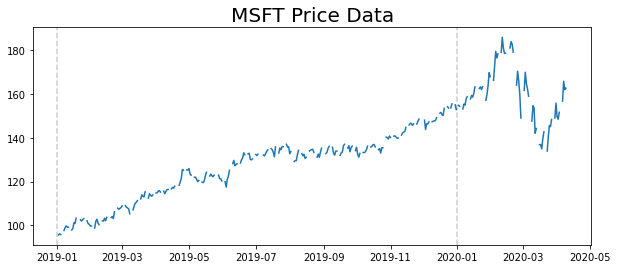

In [47]:
plt.figure(figsize=(10,4))
plt.plot(priceData)
for year in range(priceData.index[0].year, priceData.index[-1].year+1):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.2)
plt.title("%s Price Data"%tickerSymbol, fontsize=20)

**Basic Buying Protocol:**<br>
**- Buy if stock increasing for "b" consecutive days**

**Basic Selling Protocols:**<br>
**- Sell if stock decreasing for "s" consecutive days (and we've made a profit)**

In [48]:
def get_buying_selling_days(price_data, b, s):
    
    #get the percent change day after day
    pct_change = price_data.pct_change()[1:]
    
    #this function checks the buying condition
    def buying_condition(sub_series):
        return (sub_series > 0).all()
    
    #this function checks the selling condition
    def selling_condition(sub_series):
        return (sub_series < 0).all()
    
    #get all buying days in the data
    buying_days = pct_change.rolling(b).apply(buying_condition)
    
    #get all potential selling days in the data
    potential_selling_days = pct_change.rolling(s).apply(selling_condition)
    
    #return a dictionary
    return {'buying_days': buying_days, 'potential_selling_days': potential_selling_days}

In [49]:
info_dict = get_buying_selling_days(priceData, 4, 1)

In [50]:
buying_days = info_dict['buying_days']
potential_selling_days = info_dict['potential_selling_days']

In [51]:
#create dataframe to store information
df_stocks = pd.DataFrame(index = buying_days.index)

In [52]:
#populate df with buying days, possible selling days, and price
df_stocks['buying_day'] = (buying_days == 1)
df_stocks['potential_selling_day'] = (potential_selling_days == 1)
df_stocks['price'] = priceData

#only keep days that are buying or possible selling days
df_stocks = df_stocks[(df_stocks.buying_day | df_stocks.potential_selling_day)]

In [59]:
df_stocks.head(10)

,buying_day,potential_selling_day,price
Date,,,
2019-01-04,False,True,95.802697
2019-01-10,False,True,99.165226
2019-01-11,False,True,99.136375
2019-01-14,False,True,97.897067
2019-01-17,False,True,100.875303
2019-01-22,False,True,102.556539
2019-01-23,False,True,101.951293
2019-01-28,False,True,102.085810
2019-01-29,False,True,100.759980


In [54]:
def check_cumulative_percent_change(price_data, buy_date, potential_sell_date):
    """
    This helper function will check if the cumulative percent change
    between a buying and potential selling day yields overall growth
    """
    
    #get the percent change day after day
    pct_change = price_data.pct_change()[1:]
    
    sub_series = 1 + pct_change[buy_date + timedelta(hours=1): potential_sell_date]

    return sub_series.product() > 1

In [55]:
def get_investing_result(df_stocks, starting_funds, verbose=False):
    
    #get a copy of price data
    price_data = df_stocks.price
    
    #at start, not holding any shares
    holding = False
    
    #init vars
    current_funds = starting_funds
    current_shares = 0
    last_buy_date = None
    
    #init dict of buying and selling dates
    events_list = []
    
    #for each buying day and potential selling day...
    for date,data in df_stocks.iterrows():
        
        #if not currently holding shares, and this is a buying day...
        if (not holding) and data.buying_day:
            
            #calculate the number of shares we can buy
            num_shares_to_buy = int(current_funds / data.price)
            
            #update number of shares
            current_shares += num_shares_to_buy
            
            #decrease current funds
            current_funds -= num_shares_to_buy * data.price
            
            #set last buy date
            last_buy_date = date
            events_list.append(('b', date))
            
            #we are now holding shares
            holding = True
            
            if verbose:
                print('Bought %s shares at $%s on %s totaling $%s'%(num_shares_to_buy, data.price, date.date(), round(num_shares_to_buy*data.price,2)))
        
        #if you are holding shares, and this is a potential selling day...
        elif holding and data.potential_selling_day:
            
            #check to make sure we're making a profit
            if check_cumulative_percent_change(price_data, last_buy_date, date):
                #add to our current funds
                current_funds += current_shares * data.price
                
                if verbose:
                    print('Sold %s shares at $%s on %s totaling $%s'%(current_shares, data.price, date.date(), round(num_shares_to_buy*data.price,2)))
                    print('--------------------------------------')
                    
                #reset current shares
                current_shares = 0
                
                #we are no longer holding shares
                holding = False
                
                events_list.append(('s', date))
                
    #get the stock price at the end of the time span
    final_stock_price = price_data[-1]
        
    #get the final total value of all assets (funds + stock value)
    final_value = current_funds + final_stock_price * current_shares
    
    #return the percent change in value
    return round((final_value - starting_funds) / starting_funds,2), events_list

In [56]:
percent_change, events_list = get_investing_result(df_stocks, 10000, True)

Bought 90 shares at $110.51046398671623 on 2019-03-14 totaling $9945.94
Sold 90 shares at $113.26020381359048 on 2019-03-20 totaling $10193.42
--------------------------------------
Bought 88 shares at $115.87486859606864 on 2019-04-04 totaling $10196.99
Sold 88 shares at $116.97476113916305 on 2019-04-17 totaling $10293.78
--------------------------------------
Bought 82 shares at $125.48446541340556 on 2019-04-25 totaling $10289.73
Sold 82 shares at $127.24665005438152 on 2019-06-12 totaling $10434.23
--------------------------------------
Bought 78 shares at $133.10541158072 on 2019-06-20 totaling $10382.22
Sold 78 shares at $134.56768147208402 on 2019-07-16 totaling $10496.28
--------------------------------------
Bought 78 shares at $134.72425887985733 on 2019-08-22 totaling $10508.49
Sold 78 shares at $135.62790659695168 on 2019-09-09 totaling $10578.98
--------------------------------------
Bought 77 shares at $137.00760759901866 on 2019-09-20 totaling $10549.59
Sold 77 shares a

In [57]:
print(percent_change)

0.14


(90.0, 195.0)

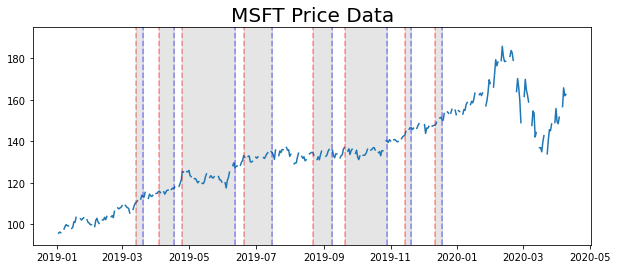

In [58]:
plt.figure(figsize=(10,4))
plt.plot(priceData)

y_lims = (int(priceData.min()*.95), int(priceData.max()*1.05))
shaded_y_lims = int(priceData.min()*.5), int(priceData.max()*1.5)

for idx, event in enumerate(events_list):
    color = 'red' if event[0] == 'b' else 'blue'
    plt.axvline(event[1], color=color, linestyle='--', alpha=0.4)
    if event[0] == 's':
        plt.fill_betweenx(range(*shaded_y_lims), 
                          event[1], events_list[idx-1][1], color='k', alpha=0.1)

plt.title("%s Price Data"%tickerSymbol, fontsize=20)
plt.ylim(*y_lims)